In [3]:
pip install --upgrade nbeats-pytorch

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tensorflow-addons

   ---------------------------------------- 0.0/729.9 kB ? eta -:--:--
    --------------------------------------- 10.2/729.9 kB ? eta -:--:--
   - ------------------------------------- 30.7/729.9 kB 435.7 kB/s eta 0:00:02
   --- ----------------------------------- 61.4/729.9 kB 469.7 kB/s eta 0:00:02
   ---- ---------------------------------- 92.2/729.9 kB 525.1 kB/s eta 0:00:02
   ------ ------------------------------- 122.9/729.9 kB 554.9 kB/s eta 0:00:02
   ------- ------------------------------ 153.6/729.9 kB 541.0 kB/s eta 0:00:02
   ---------- --------------------------- 194.6/729.9 kB 620.6 kB/s eta 0:00:01
   ----------- -------------------------- 225.3/729.9 kB 626.9 kB/s eta 0:00:01
   ------------ ------------------------- 235.5/729.9 kB 600.7 kB/s eta 0:00:01
   -------------- ----------------------- 276.5/729.9 kB 609.2 kB/s eta 0:00:01
   --------------- ---------------------- 307.2/729.9 kB 613.6 kB/s eta 0:00:01
   ----------------- -------------------- 337.9/729.9 kB 

In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Rastgele tohumları ayarlama
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seeds()

# Veri yüklenir ve işlenir
df = pd.read_excel("rainfall-and-daily-consumption-data-on-istanbul-dams.xlsx")
df = df[['Tarih', 'İstanbul günlük tüketim(m³/gün)']]
df = df.set_index("Tarih")
df.index = pd.to_datetime(df.index)
df['İstanbul günlük tüketim(m³/gün)'] = df['İstanbul günlük tüketim(m³/gün)'] // 100
df['İstanbul günlük tüketim(m³/gün)'] = df['İstanbul günlük tüketim(m³/gün)'].astype(float)
df = np.log(df)

# Eğitim ve test veri setlerini ayırma
train_size = int(len(df) * 0.80)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Özellikleri oluşturma
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'İstanbul günlük tüketim(m³/gün)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Veriyi normalize etme
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# N-BEATS modeli oluşturma
def build_nbeats_model(input_shape, horizon):
    input_layer = Input(shape=(input_shape,))
    x = input_layer
    for _ in range(4):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
    forecast = Dense(horizon)(x)
    model = Model(inputs=input_layer, outputs=forecast)
    return model

input_shape = X_train_scaled.shape[1]
horizon = 1  # Tek bir adım öngörü
nbeats_model = build_nbeats_model(input_shape, horizon)
nbeats_model.compile(optimizer='adam', loss='mse')

# EarlyStopping geri çağırmasını tanımlama
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=60, 
                        verbose=1, mode='auto', restore_best_weights=True)

# Modelin eğitimi
history = nbeats_model.fit(X_train_scaled, y_train_scaled,
                           validation_data=(X_test_scaled, y_test_scaled),
                           callbacks=[monitor],
                           verbose=1,
                           epochs=50,
                           batch_size=32)

# Test veri seti üzerinde tahmin yapılır
y_pred_scaled = nbeats_model.predict(X_test_scaled)

# Tahminleri orijinal ölçeğe döndürme
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_orig = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Hata metriklerini hesaplama
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig) * 100

print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
print("Mean Absolute Error (MAE): {:.4f}".format(mae))
print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape))

Epoch 1/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0300 - val_loss: 0.0104
Epoch 2/50
118/118 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0098
Epoch 3/50
118/118 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0203
Epoch 4/50
118/118 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0147
Epoch 5/50
118/118 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0087
Epoch 6/50
118/118 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0126
Epoch 7/50
118/118 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0098
Epoch 8/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0067 - val_loss: 0.0095
Epoch 9/50
118/118 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0086
Epoch 10/50
118/118 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0089

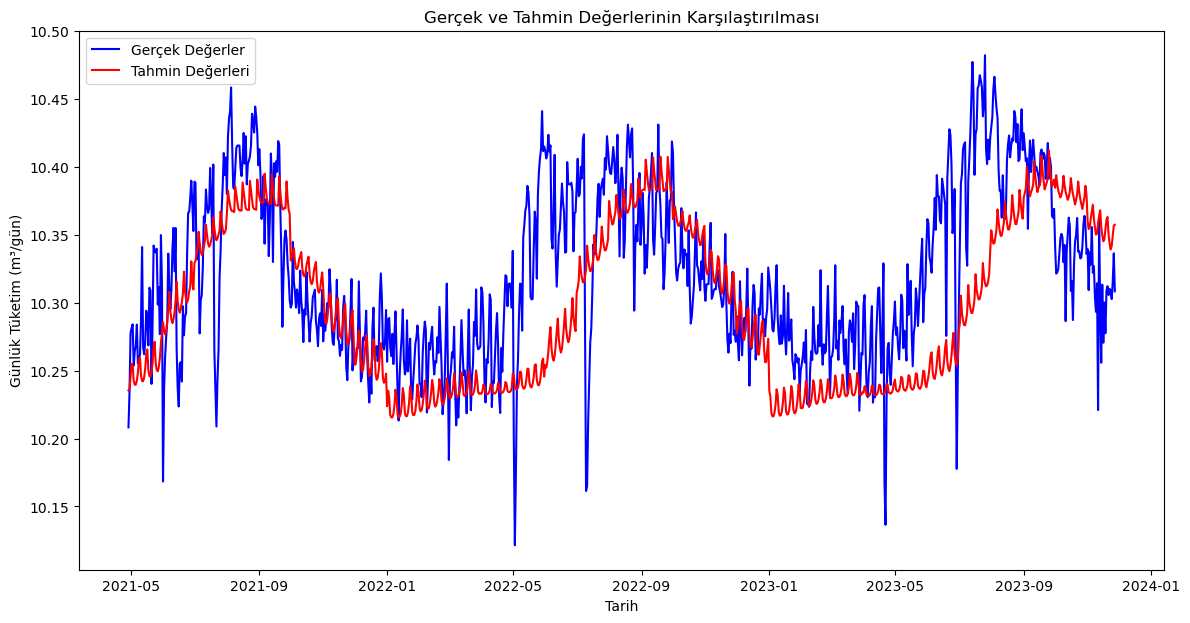

In [33]:
# Gerçek ve tahmin değerleri birleştirme
results = pd.DataFrame({'Tarih': test.index, 'Gerçek': y_test_orig.flatten(), 'Tahmin': y_pred_orig.flatten()})
results = results.set_index('Tarih')

# Görselleştirme
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Gerçek'], label='Gerçek Değerler', color='blue')
plt.plot(results.index, results['Tahmin'], label='Tahmin Değerleri', color='red')
plt.title('Gerçek ve Tahmin Değerlerinin Karşılaştırılması')
plt.xlabel('Tarih')
plt.ylabel('Günlük Tüketim (m³/gün)')
plt.legend()
plt.show()

In [34]:
# Gelecek 10 gün için tahminler yapma
future_dates_10 = [last_date + pd.Timedelta(days=i) for i in range(1, 11)]

future_df_10 = pd.DataFrame(index=future_dates_10)
future_df_10 = create_features(future_df_10)

# Özellikleri normalize etme
future_scaled_10 = scaler_X.transform(future_df_10[FEATURES])

# Gelecek 10 gün için tahminler yapma
future_pred_scaled_10 = nbeats_model.predict(future_scaled_10)

# Tahminleri orijinal ölçeğe döndürme
future_pred_orig_10 = scaler_y.inverse_transform(future_pred_scaled_10)

# Sonuçları birleştirme
future_df_10['Tahmin Edilen Su Tüketimi (m³/gün)'] = future_pred_orig_10
future_df_10['Tahmin Edilen Su Tüketimi (m³/gün)']

1/1 [==============================] - 0s 25ms/step


2023-11-28    10.343275
2023-11-29    10.336548
2023-11-30    10.332479
2023-12-01    10.317136
2023-12-02    10.324561
2023-12-03    10.333534
2023-12-04    10.334232
2023-12-05    10.315685
2023-12-06    10.307896
2023-12-07    10.305132
Name: Tahmin Edilen Su Tüketimi (m³/gün), dtype: float32

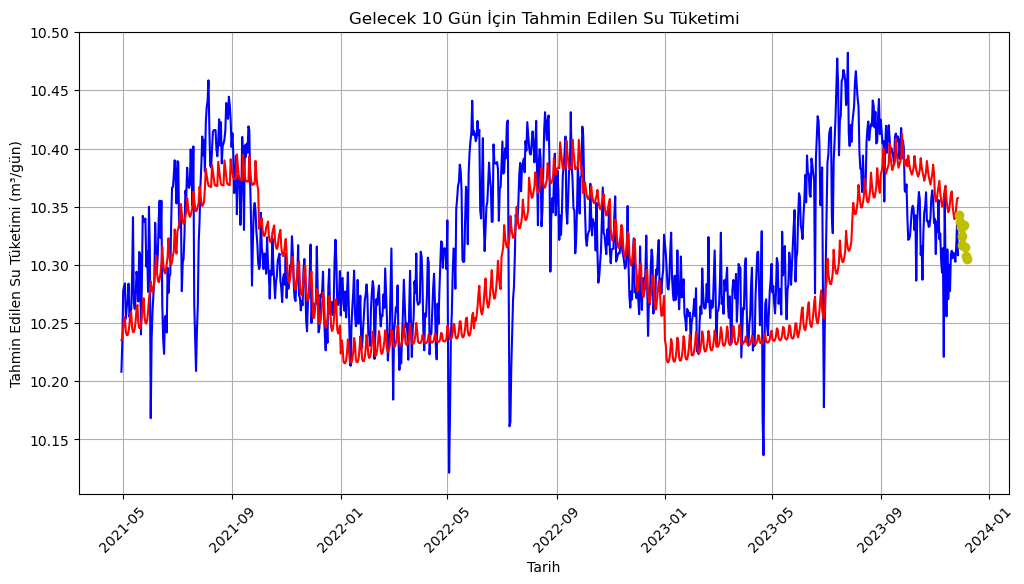

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Gerçek'], label='Gerçek Değerler', color='blue')
plt.plot(results.index, results['Tahmin'], label='Tahmin Değerleri', color='red')
plt.plot(future_df_10.index, future_df_10['Tahmin Edilen Su Tüketimi (m³/gün)'], marker='o', linestyle='-', color='y')
plt.title('Gelecek 10 Gün İçin Tahmin Edilen Su Tüketimi')
plt.xlabel('Tarih')
plt.ylabel('Tahmin Edilen Su Tüketimi (m³/gün)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

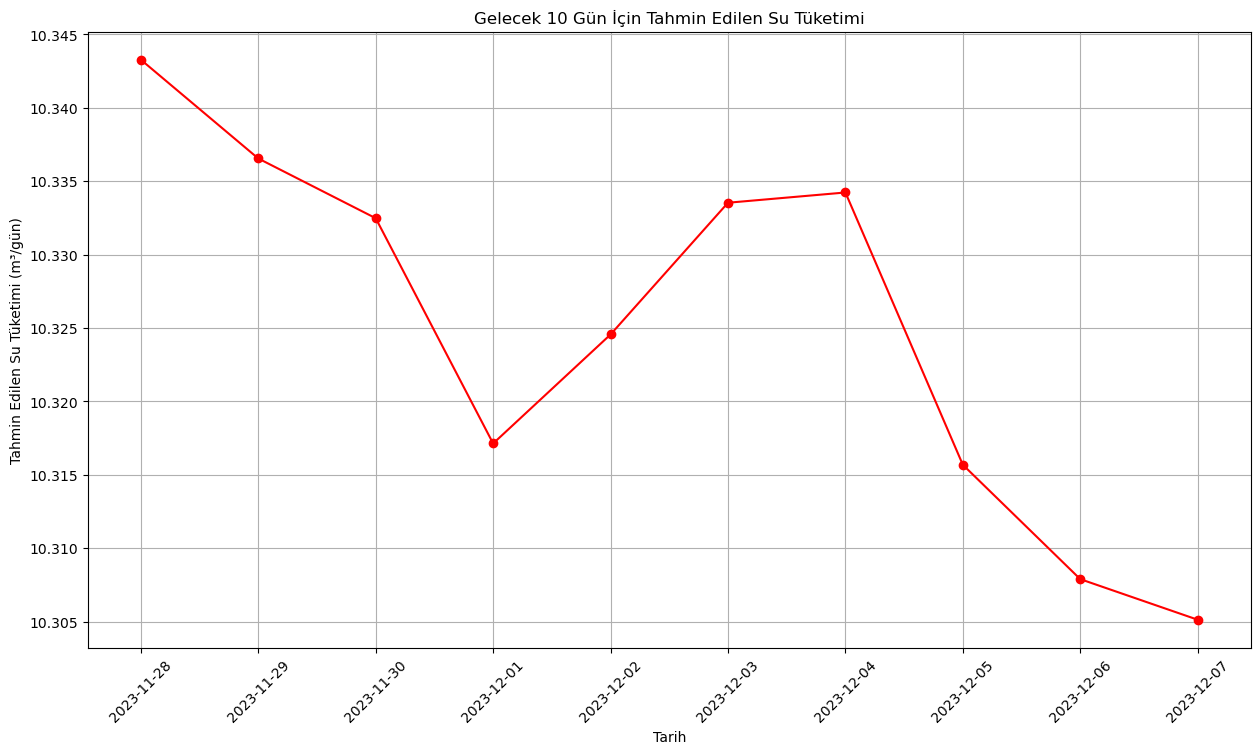

In [36]:
# Tahmin edilen su tüketimini görselleştirme (10 gün)
plt.figure(figsize=(15, 8))
plt.plot(future_df_10.index, future_df_10['Tahmin Edilen Su Tüketimi (m³/gün)'], marker='o', linestyle='-', color='r')
plt.title('Gelecek 10 Gün İçin Tahmin Edilen Su Tüketimi')
plt.xlabel('Tarih')
plt.ylabel('Tahmin Edilen Su Tüketimi (m³/gün)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [37]:
# Gelecek 365 gün için tahminler yapma
last_date = df.index[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 366)]

future_df = pd.DataFrame(index=future_dates)
future_df = create_features(future_df)

# Özellikleri normalize etme
future_scaled = scaler_X.transform(future_df[FEATURES])

# Gelecek 365 gün için tahminler yapma
future_pred_scaled = model.predict(future_scaled)

# Tahminleri orijinal ölçeğe döndürme
future_pred_orig = scaler_y.inverse_transform(future_pred_scaled)

# Sonuçları birleştirme
future_df['Tahmin Edilen Su Tüketimi (m³/gün)'] = future_pred_orig
future_df['Tahmin Edilen Su Tüketimi (m³/gün)']

12/12 [==============================] - 0s 5ms/step


2023-11-28    10.365890
2023-11-29    10.352673
2023-11-30    10.348421
2023-12-01    10.344475
2023-12-02    10.345436
                ...    
2024-11-22    10.400943
2024-11-23    10.400170
2024-11-24    10.398359
2024-11-25    10.402020
2024-11-26    10.397069
Name: Tahmin Edilen Su Tüketimi (m³/gün), Length: 365, dtype: float32

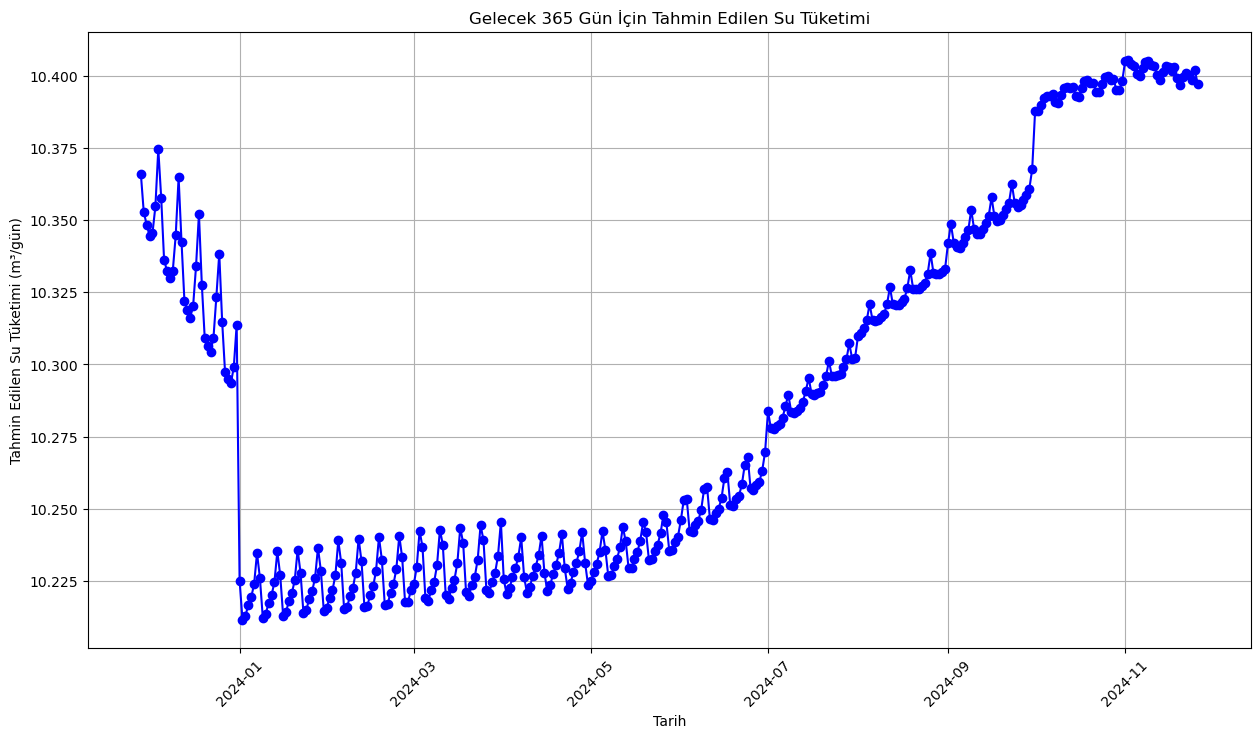

In [38]:
# Tahmin edilen su tüketimini görselleştirme
plt.figure(figsize=(15, 8))
plt.plot(future_df.index, future_df['Tahmin Edilen Su Tüketimi (m³/gün)'], marker='o', linestyle='-', color='b')
plt.title('Gelecek 365 Gün İçin Tahmin Edilen Su Tüketimi')
plt.xlabel('Tarih')
plt.ylabel('Tahmin Edilen Su Tüketimi (m³/gün)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()